Скачиваем библы

In [ ]:
# !pip install yfinance
# !pip install keras
# !pip install yahoofinancials


In [ ]:
import yfinance as yf
import yahoofinancials
import math 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Загружаем данные

In [ ]:
AAPL = yf.download('AAPL', 
                      start='2015-01-04', 
                      end='2021-09-21', 
                      progress=False)
AAPL

AAPL_TEST = yf.download('AAPL', 
                      start='2021-09-21', 
                      end='2021-10-01', 
                      progress=False)
print(AAPL['Close'])
print(AAPL_TEST['Close'])

Date
2015-01-05     26.562500
2015-01-06     26.565001
2015-01-07     26.937500
2015-01-08     27.972500
2015-01-09     28.002501
                 ...    
2021-09-14    148.119995
2021-09-15    149.029999
2021-09-16    148.789993
2021-09-17    146.059998
2021-09-20    142.940002
Name: Close, Length: 1690, dtype: float64
Date
2021-09-21    143.429993
2021-09-22    145.850006
2021-09-23    146.830002
2021-09-24    146.919998
2021-09-27    145.369995
2021-09-28    141.910004
2021-09-29    142.830002
2021-09-30    141.500000
Name: Close, dtype: float64


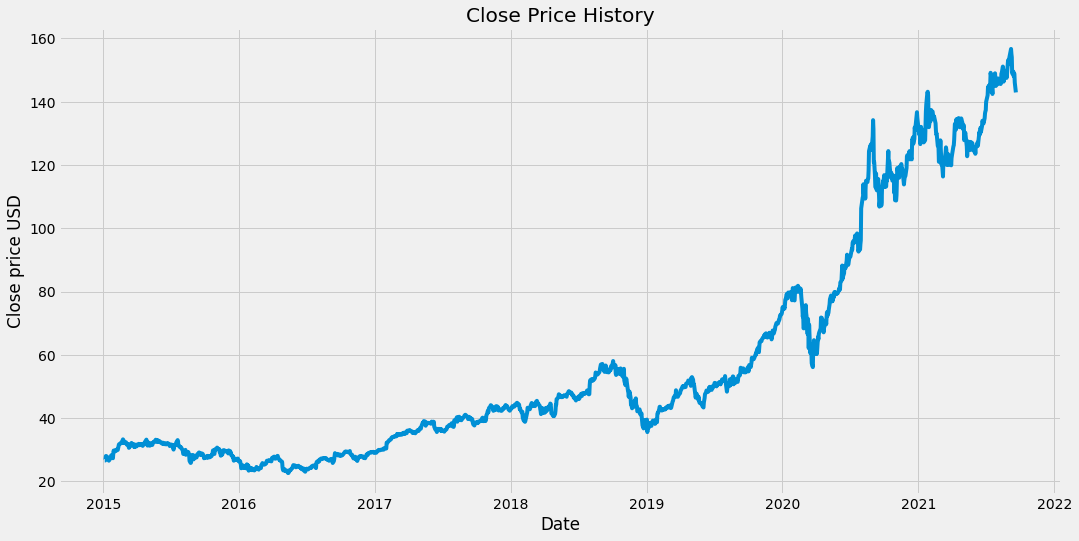

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Close Price History')
plt.plot(AAPL['Close'])
plt.xlabel('Date')
plt.ylabel('Close price USD')
plt.show()

In [ ]:
data = AAPL.filter(['Close'])
data_test = AAPL_TEST.filter(['Close'])
dataset = data.values
dataset_test = data_test.values
training_data_len = math.ceil(len(dataset) * .8)

Нормализация 

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset) 


Создаем датасет для обучения 

In [ ]:
# Создаем датасет для обучения
train_data = scaled_data[0:training_data_len]
# разбиваем на x underscore train и y underscore train 
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

In [ ]:
#Конвертируем x_train и y_train в нумпаевский массив
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],x_train.shape[2]))
x_train.shape

(1292, 60, 1)

### Строим нейронку

In [ ]:
#Строим нейронку
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

Тренируем Модель

In [ ]:
#Тренируем модель
model.fit(x_train,y_train,batch_size = 1, epochs = 10)

Epoch 1/10
1292/1292 [==============================] - 33s 23ms/step - loss: 6.7534e-04
Epoch 2/10
1292/1292 [==============================] - 30s 23ms/step - loss: 2.9056e-04
Epoch 3/10
1292/1292 [==============================] - 31s 24ms/step - loss: 2.0757e-04
Epoch 4/10
1292/1292 [==============================] - 30s 23ms/step - loss: 1.5622e-04
Epoch 5/10
1292/1292 [==============================] - 31s 24ms/step - loss: 1.6022e-04
Epoch 6/10
1292/1292 [==============================] - 30s 24ms/step - loss: 1.1388e-04
Epoch 7/10
1292/1292 [==============================] - 31s 24ms/step - loss: 1.2511e-04
Epoch 8/10
1292/1292 [==============================] - 30s 23ms/step - loss: 1.2858e-04
Epoch 9/10
1292/1292 [==============================] - 31s 24ms/step - loss: 1.4491e-04
Epoch 10/10
1292/1292 [==============================] - 31s 24ms/step - loss: 1.1029e-04


Создаем тестовый датасет 

(20340,)
339
(20400,)
340
(20460,)
341
[array([138.6918], dtype=float32), array([134.74908], dtype=float32), array([131.13242], dtype=float32)]
[138.6918, 134.74908, 131.13242]


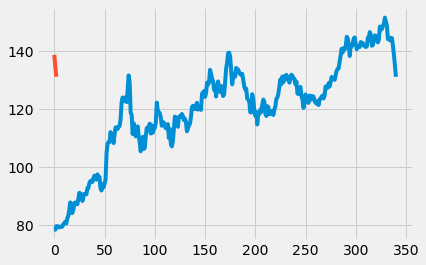

In [ ]:
from tqdm import tqdm
#Создаем тестовый датасет
test_data = scaled_data[training_data_len - 60:]
#по аналогии создаем x_test и y_test 
x_test_pred_final = []
y_test = dataset[training_data_len:]
for j in range(3):
  x_test = []
  x_test_pred = []
  for i in range(60,len(test_data)+1):
      x_test=np.append(x_test,np.array(test_data[i-60:i]))
      if (i == len(test_data)):
        x_test_pred.append(test_data[i-60:i])
  
  print(x_test.shape)
  x_test_pred = np.array(x_test_pred)
  x_test = np.reshape(x_test,(x_test.shape[0]//60,60,1))
  x_test_pred = np.reshape(x_test_pred,(1,60,1))
  predictions = model.predict(x_test)
  print(len(predictions))
  test_data=np.append(test_data, predictions[len(predictions)-1:])
  x_test_pred_final.append(scaler.inverse_transform(predictions[len(predictions)-1:]))
  
plt.plot(scaler.inverse_transform(predictions))
lst = []
for el in x_test_pred_final:
  lst.extend(el)
print(lst)
lst2=[]
for el2 in lst:
  lst2.extend(el2)
print(lst2)
plt.plot(lst2)

In [ ]:
from sklearn.metrics import r2_score
y_test=dataset_test[0:3]
rmse =np.sqrt(np.mean(lst2-y_test)**2)

r2 = r2_score(lst2,y_test)
print('pred:',lst2)
print('real:', y_test)

pred: [138.6918, 134.74908, 131.13242]
real: [[143.42999268]
 [145.8500061 ]
 [146.83000183]]


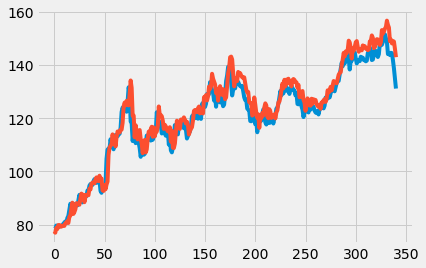

In [ ]:
plt.plot(scaler.inverse_transform(predictions))
plt.plot(dataset[len(dataset)-len(predictions):])
plt.show()